Import Required Libraries

In [1]:
# GAN for MNIST Digit Generation

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

In [2]:
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 Set Hyperparameters

In [3]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 50
batch_size = 100
sample_dir = 'samples'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Load Dataset


In [4]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

mnist = torchvision.datasets.MNIST(root='data/', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:14<00:00, 675322.54it/s] 


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 115554.75it/s]


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:02<00:00, 611650.62it/s]


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4281979.94it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



Define the Discriminator and Generator

In [5]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)


In [6]:
# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)


Set Loss and Optimizers

In [7]:
# Loss and optimizers
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

D.to(device)
G.to(device)


Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

 Save Sample Images Function

In [8]:
# For plotting
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def save_fake_images(index):
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_path = os.path.join(sample_dir, f'epoch_{index}.png')
    torchvision.utils.save_image(denorm(fake_images), save_path, nrow=10)


Training Loop (10 Epochs)

In [9]:
# Reduce number of epochs for faster training and quick visualization
num_epochs = 10 # You can change to 5 if needed


In [10]:
total_step = len(data_loader)
for epoch in range(1, num_epochs + 1):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)

        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i + 1}/{total_step}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')
    save_fake_images(epoch)

Epoch [1/10], Step [200/600], D Loss: 0.0529, G Loss: 3.8463, D(x): 0.99, D(G(z)): 0.04
Epoch [1/10], Step [400/600], D Loss: 0.0218, G Loss: 5.5702, D(x): 1.00, D(G(z)): 0.02
Epoch [1/10], Step [600/600], D Loss: 0.0426, G Loss: 5.6104, D(x): 0.99, D(G(z)): 0.03
Epoch [2/10], Step [200/600], D Loss: 0.0271, G Loss: 5.1593, D(x): 0.99, D(G(z)): 0.02
Epoch [2/10], Step [400/600], D Loss: 0.2182, G Loss: 5.1604, D(x): 0.93, D(G(z)): 0.03
Epoch [2/10], Step [600/600], D Loss: 0.1890, G Loss: 4.9424, D(x): 0.93, D(G(z)): 0.04
Epoch [3/10], Step [200/600], D Loss: 0.4319, G Loss: 2.6530, D(x): 0.83, D(G(z)): 0.13
Epoch [3/10], Step [400/600], D Loss: 0.3476, G Loss: 3.8836, D(x): 0.86, D(G(z)): 0.06
Epoch [3/10], Step [600/600], D Loss: 0.4219, G Loss: 5.2071, D(x): 0.80, D(G(z)): 0.06
Epoch [4/10], Step [200/600], D Loss: 1.4760, G Loss: 1.6252, D(x): 0.57, D(G(z)): 0.33
Epoch [4/10], Step [400/600], D Loss: 1.1134, G Loss: 2.8231, D(x): 0.82, D(G(z)): 0.40
Epoch [4/10], Step [600/600], D 

In [11]:
# Save fake images
save_fake_images(epoch)

# Save final models
torch.save(G.state_dict(), 'G.pth')
torch.save(D.state_dict(), 'D.pth')


Visualize Images Across Epochs

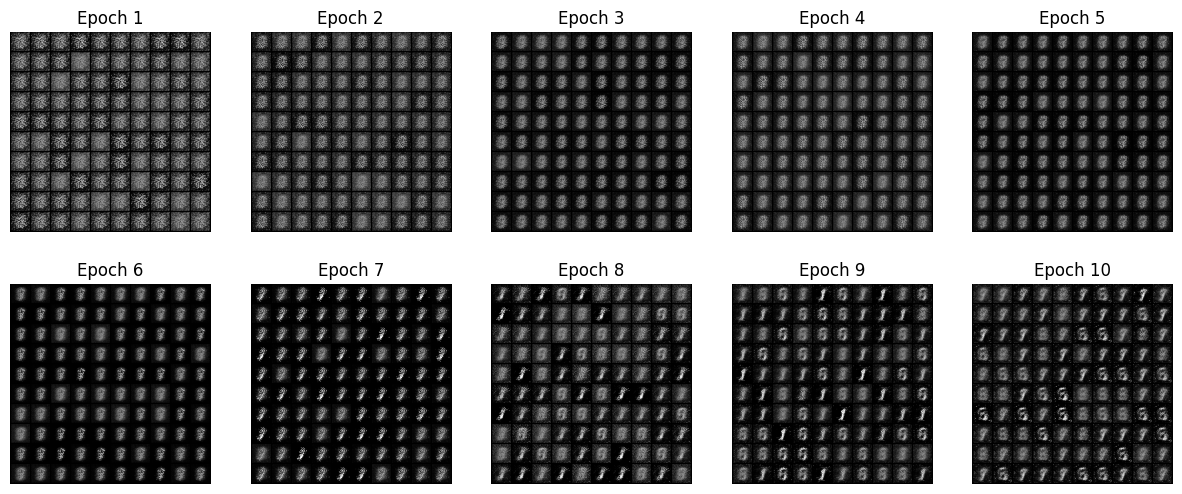

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display images from selected epochs
selected_epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Corrected to match the number of epochs
plt.figure(figsize=(15, 6))

for i, epoch in enumerate(selected_epochs):
    img_path = os.path.join(sample_dir, f'epoch_{epoch}.png')
    # Check if the file exists before trying to read it
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Epoch {epoch}')
        plt.axis('off')
    else:
        print(f"Image for epoch {epoch} not found at {img_path}")

plt.show()